In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
wine_qual_df = pd.read_csv('../data/winequalityN.csv')
wine_qual_df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

Создадим новую переменную *quality_label*, которая категоризирует оценки экспертов на низкокачественное (<5), среднекачественное (>5 & <7) и высокакачественное (>7) вина.

In [5]:
wine_qual_df['quality_label'] = wine_qual_df.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')

In [6]:
wine_qual_df['quality_label']

0       medium
1       medium
2       medium
3       medium
4       medium
         ...  
6492       low
6493    medium
6494    medium
6495       low
6496    medium
Name: quality_label, Length: 6497, dtype: object

Так как признаки данного набора данных представляют из себя химические хар-ки вин, а красное и белое вино имеют значимые различия на химическом уровне, дальнейшую обработку и анализ данных лучше производить отдельно для красных и белых вин.

Убедимся в стат. значимых различиях признаков красных и белых вин:

In [7]:
chemical_feats = [column for column in wine_qual_df if column not in ['quality_label', 'quality', 'type']]

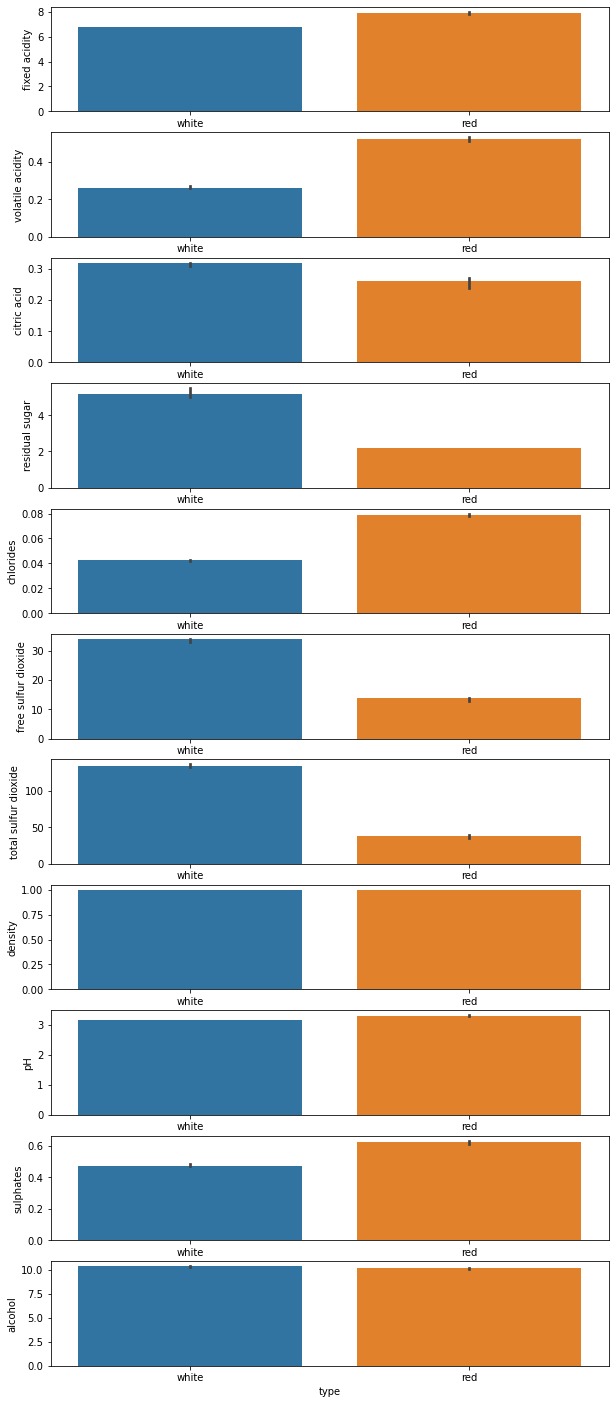

In [8]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,25))
for i, feat in enumerate(chemical_feats):
     sns.barplot(y=wine_qual_df[feat], x=wine_qual_df['type'], estimator=np.median, ax=axs[i])

Видим, что стат. значимые различия отсутствуют только в крепости (*alcohol*) и плтоности (*density*) вин.

Видим, что таргетные метки качества сильно несбалансированы, высокую оценку получили всего 198 вин:

In [9]:
wine_qual_df['quality_label'].value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

Присутствуют пропущенные значения, но их не так уж и много, в данной работе решил заполнять пропуски после фильтрации выбросов, плюс, отфильтрованные значения не будут удаляться, а просто их значения будут заменяться на NaN и в дальнейшем с остальными пропусками заполнятся аналогичным образом.

In [10]:
wine_qual_df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
quality_label            0
dtype: int64

Построим графики boxplot для количественных переменных:

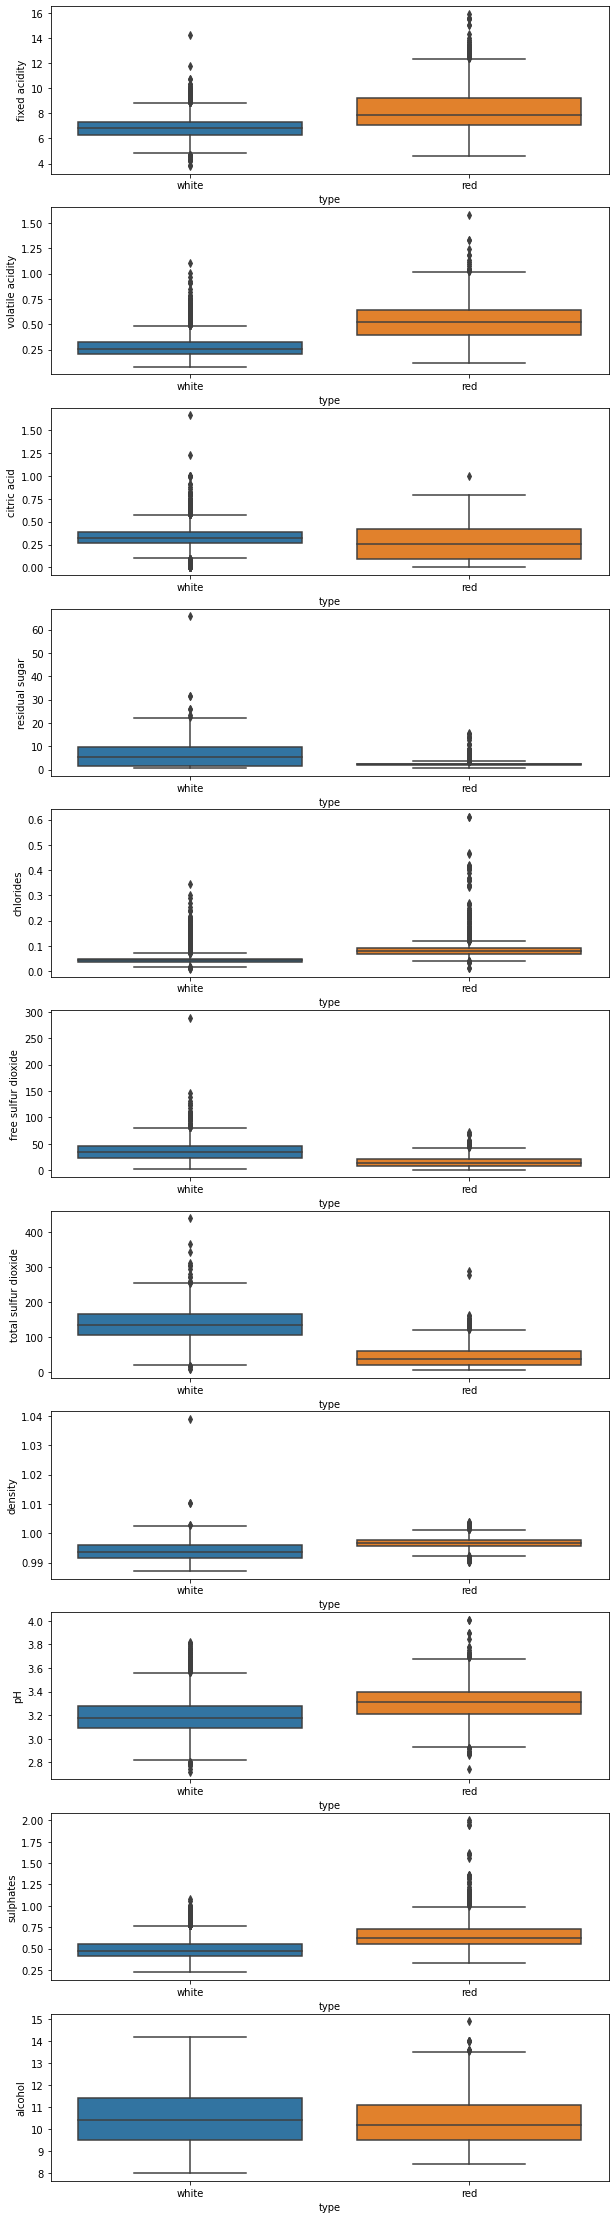

In [11]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,40))
for i, feat in enumerate(chemical_feats):
     sns.boxplot(y=wine_qual_df[feat], x=wine_qual_df['type'], ax=axs[i])

Можно опять пронаблюдать различия в медианах выборок и наличие множества выбросов, заменим наблюдения, выпадающие за интервал 
[Q1-1.5*IQR, Q3+1.5*IQR], на *Nan* значения, далее заполним их средними значениями для соответствующих выборок. 

In [12]:
for wine_type in ['white', 'red']:
    for column in chemical_feats:
        Q1 = wine_qual_df.loc[wine_qual_df['type']==wine_type, column].quantile(0.25)
        Q3 = wine_qual_df.loc[wine_qual_df['type']==wine_type, column].quantile(0.75)
        IQR = Q3 - Q1
        filter_cond = ((wine_qual_df[column]<(Q1 - 1.5*IQR))| (wine_qual_df[column]>(Q3 + 1.5*IQR)))
        wine_qual_df.loc[(wine_qual_df['type']==wine_type)&(filter_cond),column] = np.nan 

Ещё раз построим boxplot'ы и проверим, что фильтрация прошла успешно

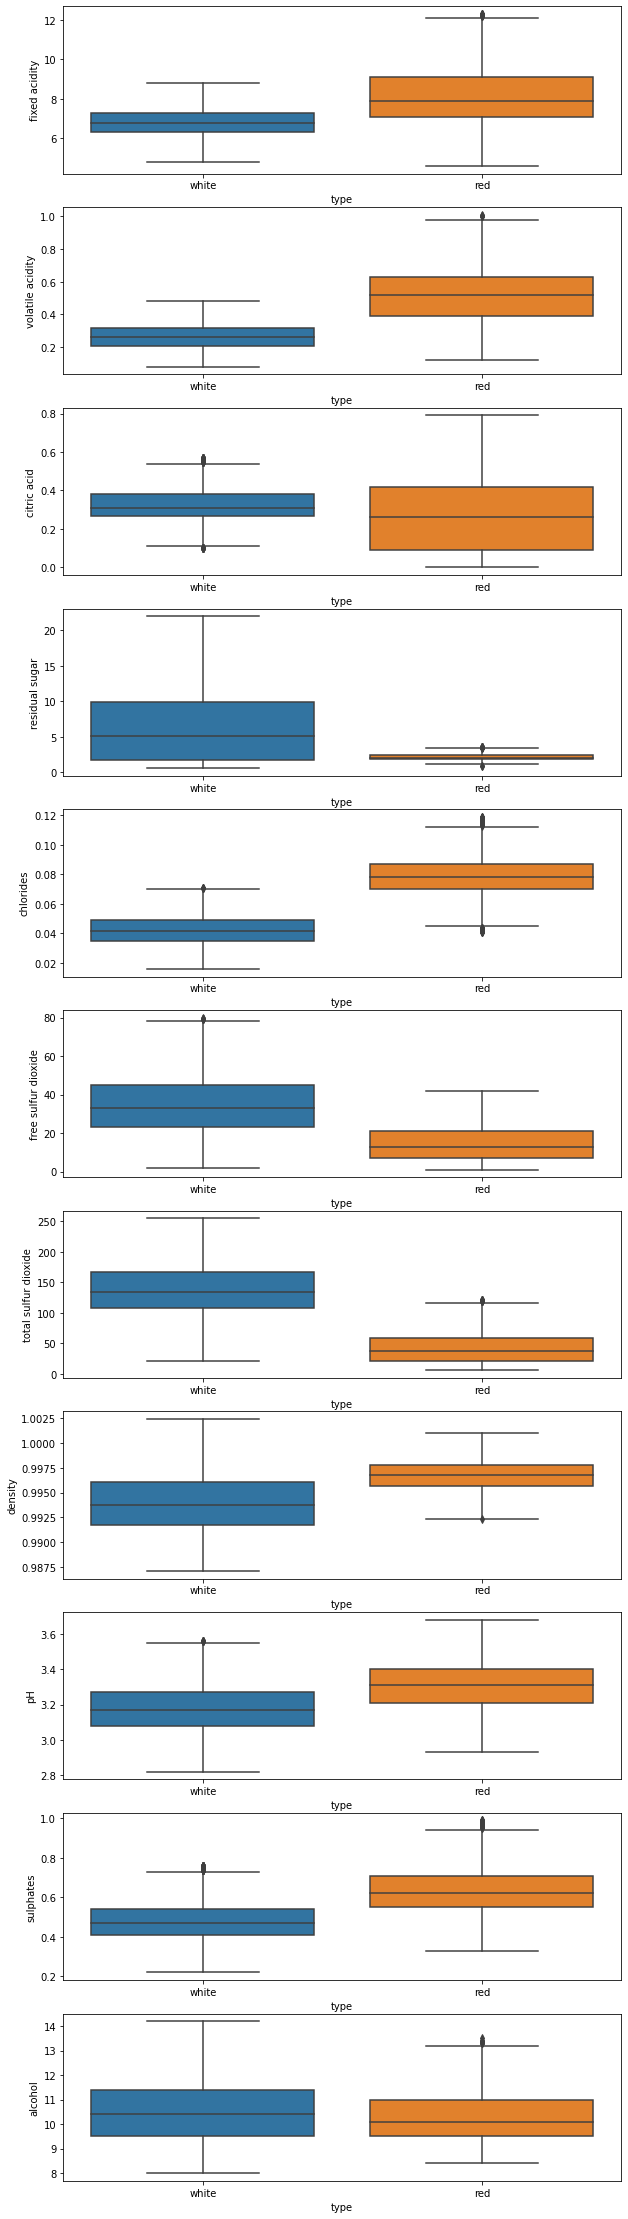

In [13]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,40))
for i, feat in enumerate(chemical_feats):
     sns.boxplot(y=wine_qual_df[feat], x=wine_qual_df['type'], ax=axs[i])

Заменим пропущенные значения соответствующими средними значениями выборки признака в зависимости от типа вина:

In [14]:
for wine_type in ['white', 'red']:
    wine_qual_df[wine_qual_df['type']==wine_type] = wine_qual_df[wine_qual_df['type']==wine_type]. \
                                        fillna(wine_qual_df[wine_qual_df['type']==wine_type].median())

In [15]:
wine_qual_df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_label           0
dtype: int64

Посмотрим на медианные значения количественных признаков в зависимости от типа вина и метки качества:

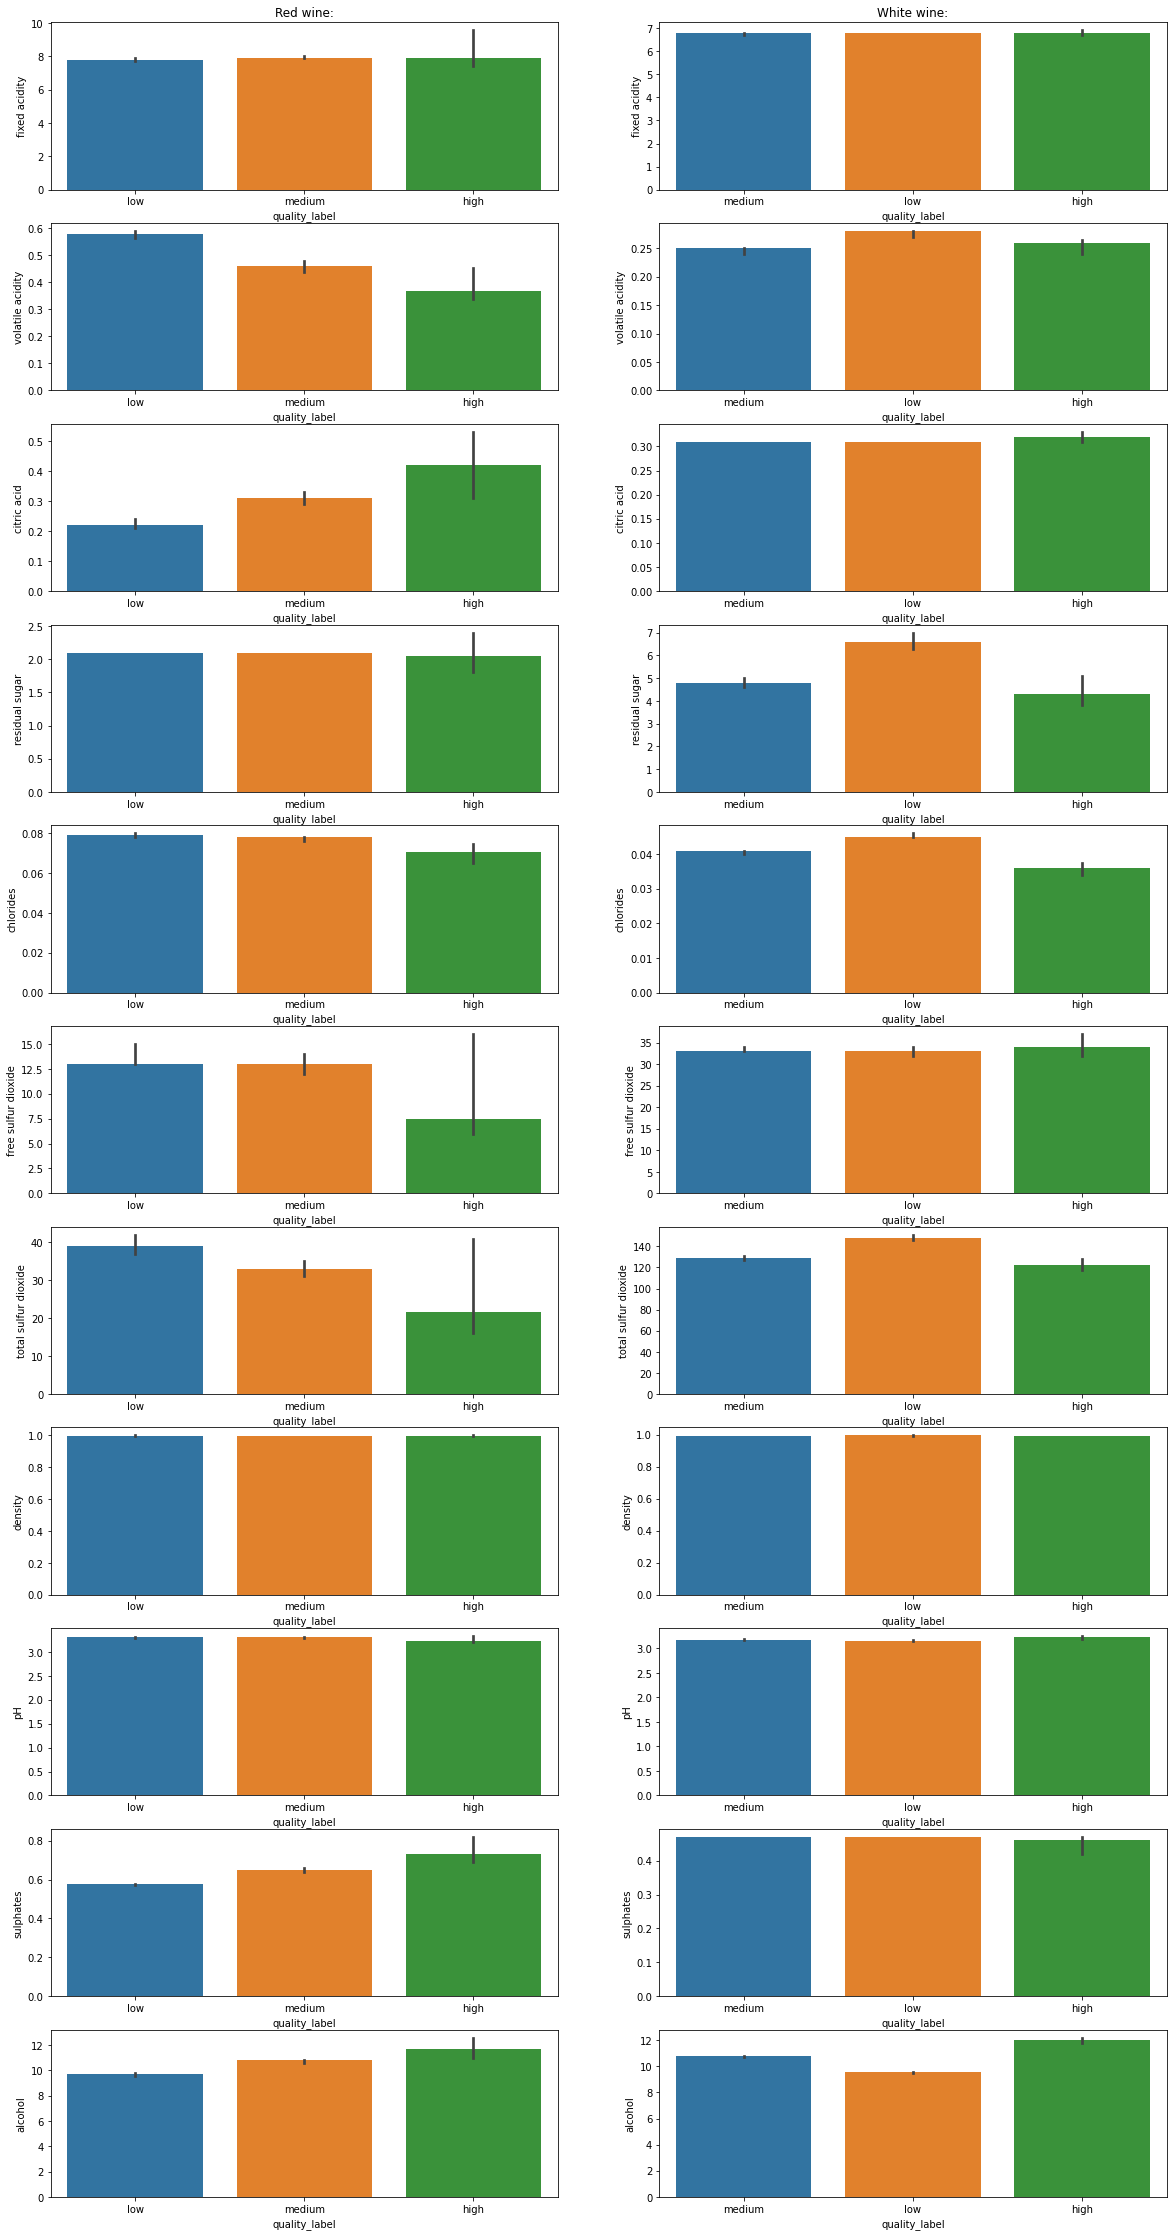

In [16]:
_, axs = plt.subplots(len(chemical_feats), 2, figsize=(20,40))
red_wine = wine_qual_df[wine_qual_df['type']=='red'].copy()
white_wine = wine_qual_df[wine_qual_df['type']=='white'].copy()
axs[0, 0].set_title('Red wine:')
axs[0, 1].set_title('White wine:')
for i, feat in enumerate(chemical_feats):
    sns.barplot(y=red_wine[feat], x=red_wine['quality_label'], estimator=np.median, ax=axs[i, 0])
    sns.barplot(y=white_wine[feat], x=white_wine['quality_label'], estimator=np.median, ax=axs[i, 1])


Во-первых можно обратить внимание на большие дов. интервалы для высоких оценок белых и особенно красных вин, это связано с тем, что красных высокооцененных вин в наборе данных всего 18, а белых хоть и в десять раз больше, но относительно мало. По этой причине довольно сложно определить стат. значимые различия характеристик в высокооцененных винах относительно остальных вин. Тем не менее, по полученным результатам можно сделать выводы:

- Для красных вин:

    - фиксированная кислотность никак стат. значимо не разделяет вина относительно полученных баллов;
    - летучая кислотность разделяет стат. значимо низкооцененные вина от средне- и восокооцененных вин, следовательно, относительно более высокое содержание летучей кислотности отрицательно влияет на оценку экспертов;
    - лимонная кислота в красных винах наоборот более располагает экспертов, низкооцененные красные вина имеют стат. значимые отличия от остальных;
    - содержание натурального сахара в красном вине никак стат. значимо не влияет на выбор экспертов;
    - концентрация хлоридов тоже не дает стат. значимых различий между всеми метками оценок, но между высокой и низкой оценкой эти различия присутствуют, более низкое содержание хлоридов в красном вине соответствует высоким оценкам;
    - концентрация свободного диоксида серы не дает стат. значимых различий;
    - а суммарная концентрация сульфадов дает стат. значимые различия между средне- и низкооцененными красными винами, более низкая концентрация сульфадов соответствует более высоким оценкам;
    - плотность и кислотность по водородной шкале также не дают стат. значимых различий в оценках красных вин;
    - концентрация сульфатов и крепость красного вина стат. значимо разделяют средне- и низкооцениваемые вина, их более высокие показатели соответствуют более высоким оценкам.
    
В данном случае следует с осторожностью делать выводы о стат. значимости или её отсутствии для высокооцененных красных вин, так как выборка в 18 объектов с трудом может являться репрезентативной, что и приводит к большому дов. интервалу.
    
- Для белых вин:
    - фиксированная кислотность также как и в красных винах не разделяет стат. значимо наши выборки;
    - летучая кислотность дает стат. значимые различия только между средне- и низкооцененными винами, что малоинформативно, так как обе выборки стат. значимо не различимы от высокооцененных белых вин;
    - лимонная кислота в отличие от красных вин в белых винах никак стат. значимо не влияет на оценку экспертов;
    - в случае с сахаром ситуация противоположная: более высокая концентрация сахара соответствует низкооцененным винам, а относительно более низкая - высоко- и среднеоцененным белым винам;
    - концентрация хлоридов дает стат. значимые различия для оценок белых вин: более высокая концентрация свойственна низкооцененным винам, наименьшая концентрация - высокооцененным винам, средняя - среднеоцененным;
    - концентрация свободного диоксида серы также как и для красного вина не дает стат. значимых различий;
    - суммарная концентрация сульфадов, как и в случае с летучей кислотностью, дает стат. значимые различия только относительно низкооцененных вин,им соответствует более высокая концентрация, для средне- и высокооцененных стат. значимых отличий нету;
    - далее, аналогично красным винам плотность и кислотность по водородной шкале не дают стат. значимых отличий, плюс, этих различий не дает и концентрация сульфатов, которая имела стат. значимость для красных вин;
    - крепость алкоголя, как и в случае с красным вином, стат. значимо разделяет выборку с той же тенденцией: более низкая крепость соответствует низкооцененным  винам, более высокая крепость - высокооцененным винам, а относительно средняя крепость - среднеоцененным винам.
    
В целом можно сделать вывод, что белые и красные вина все-таки довольно разные напитки, и до сих пор не понятно, почему оба сорта вин присутствуют в наборе. А во-вторых, можно отметить некоторые характеристики, которые не дали стат. значимых различий на обоих сортах вин, например, фиксированная кислотность, плотность и кислотность по водородной шкале, но большинство признаков влияют в оценке красных и белых вин по разному.


Посмотрим на корреляцию признаков для белого и красного вина:

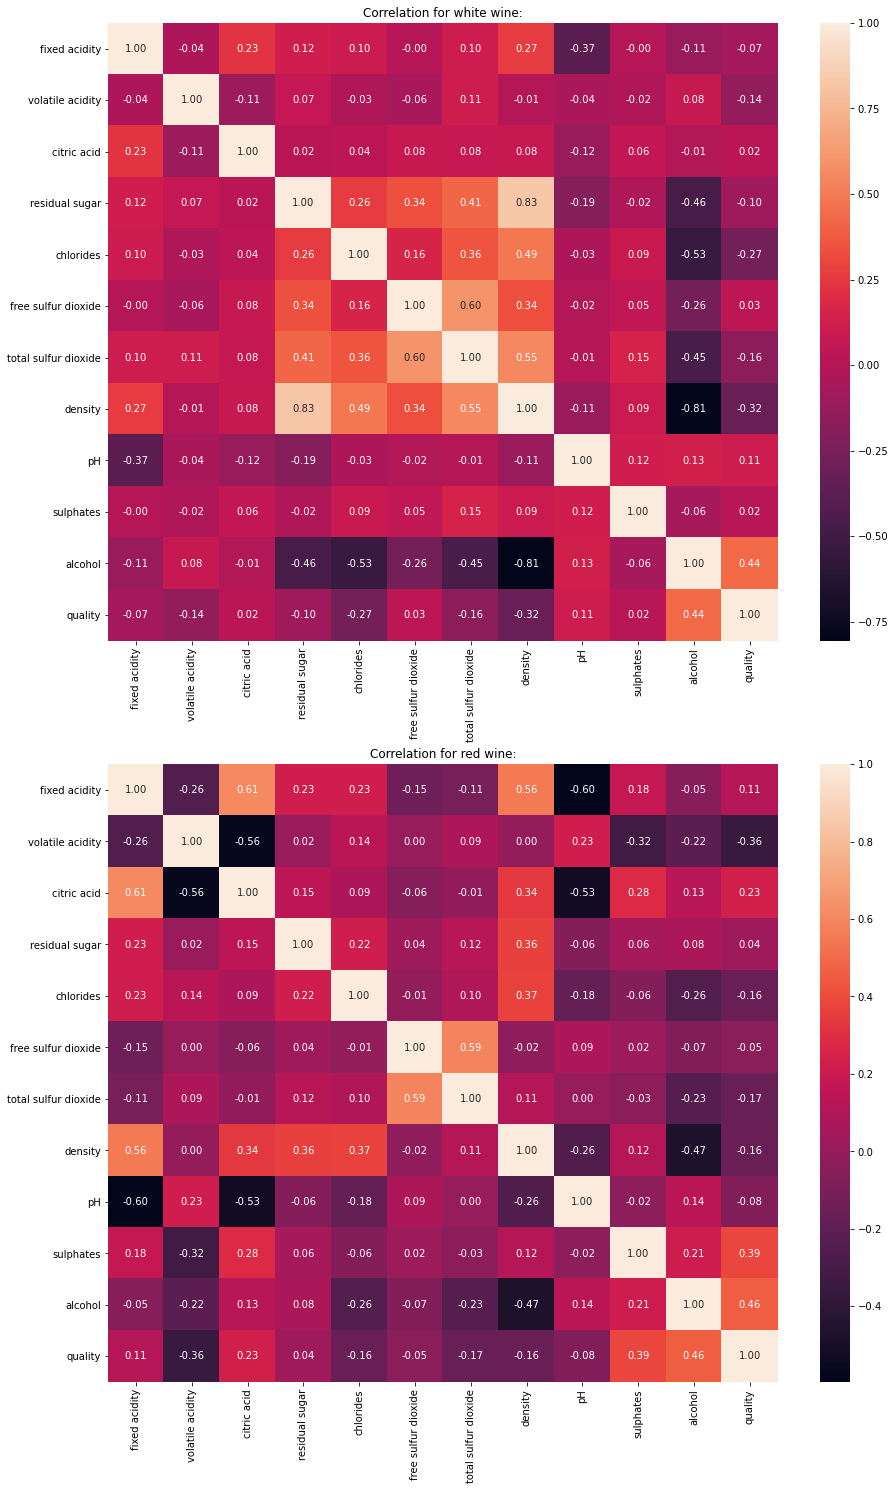

In [17]:
_, axs = plt.subplots(2, figsize=(15, 25))

for i, wine_type in enumerate(['white', 'red']):
    corr = wine_qual_df[wine_qual_df['type']==wine_type].corr()
    axs[i].set_title(f'Correlation for {wine_type} wine:')
    sns.heatmap(corr, ax=axs[i], fmt=".2f", annot=True)

Можем заметить, что для белого вина существует довольно сильная корреляция между концентрацией сахара и плотностью вина, также присутствует корреляция между плотностью и крепостью вина. У красных вин сильных корреляций между признаками не наблюдается.

В корреляции с таргетным значением качества вин можем отметить, что наибольшую корреляцию имеет признак крепости алкоголя, как отмечалось ранее, крепость алкоголя стат. значима для обоих вин и имеется тенденция отдавать предпочтение более крепким винам. Также у красных вин можем отметить относительно высокую корреляцию у концентрации сульфата, при анализе на стат. значимость также были получены положительные результаты с этим признаком, причем как и в этом случае только с красным вином.

Посмотрим также на диаграммы рассеивания для вин:

In [18]:
wine_qual_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Red wine features pairwise plots by quality:


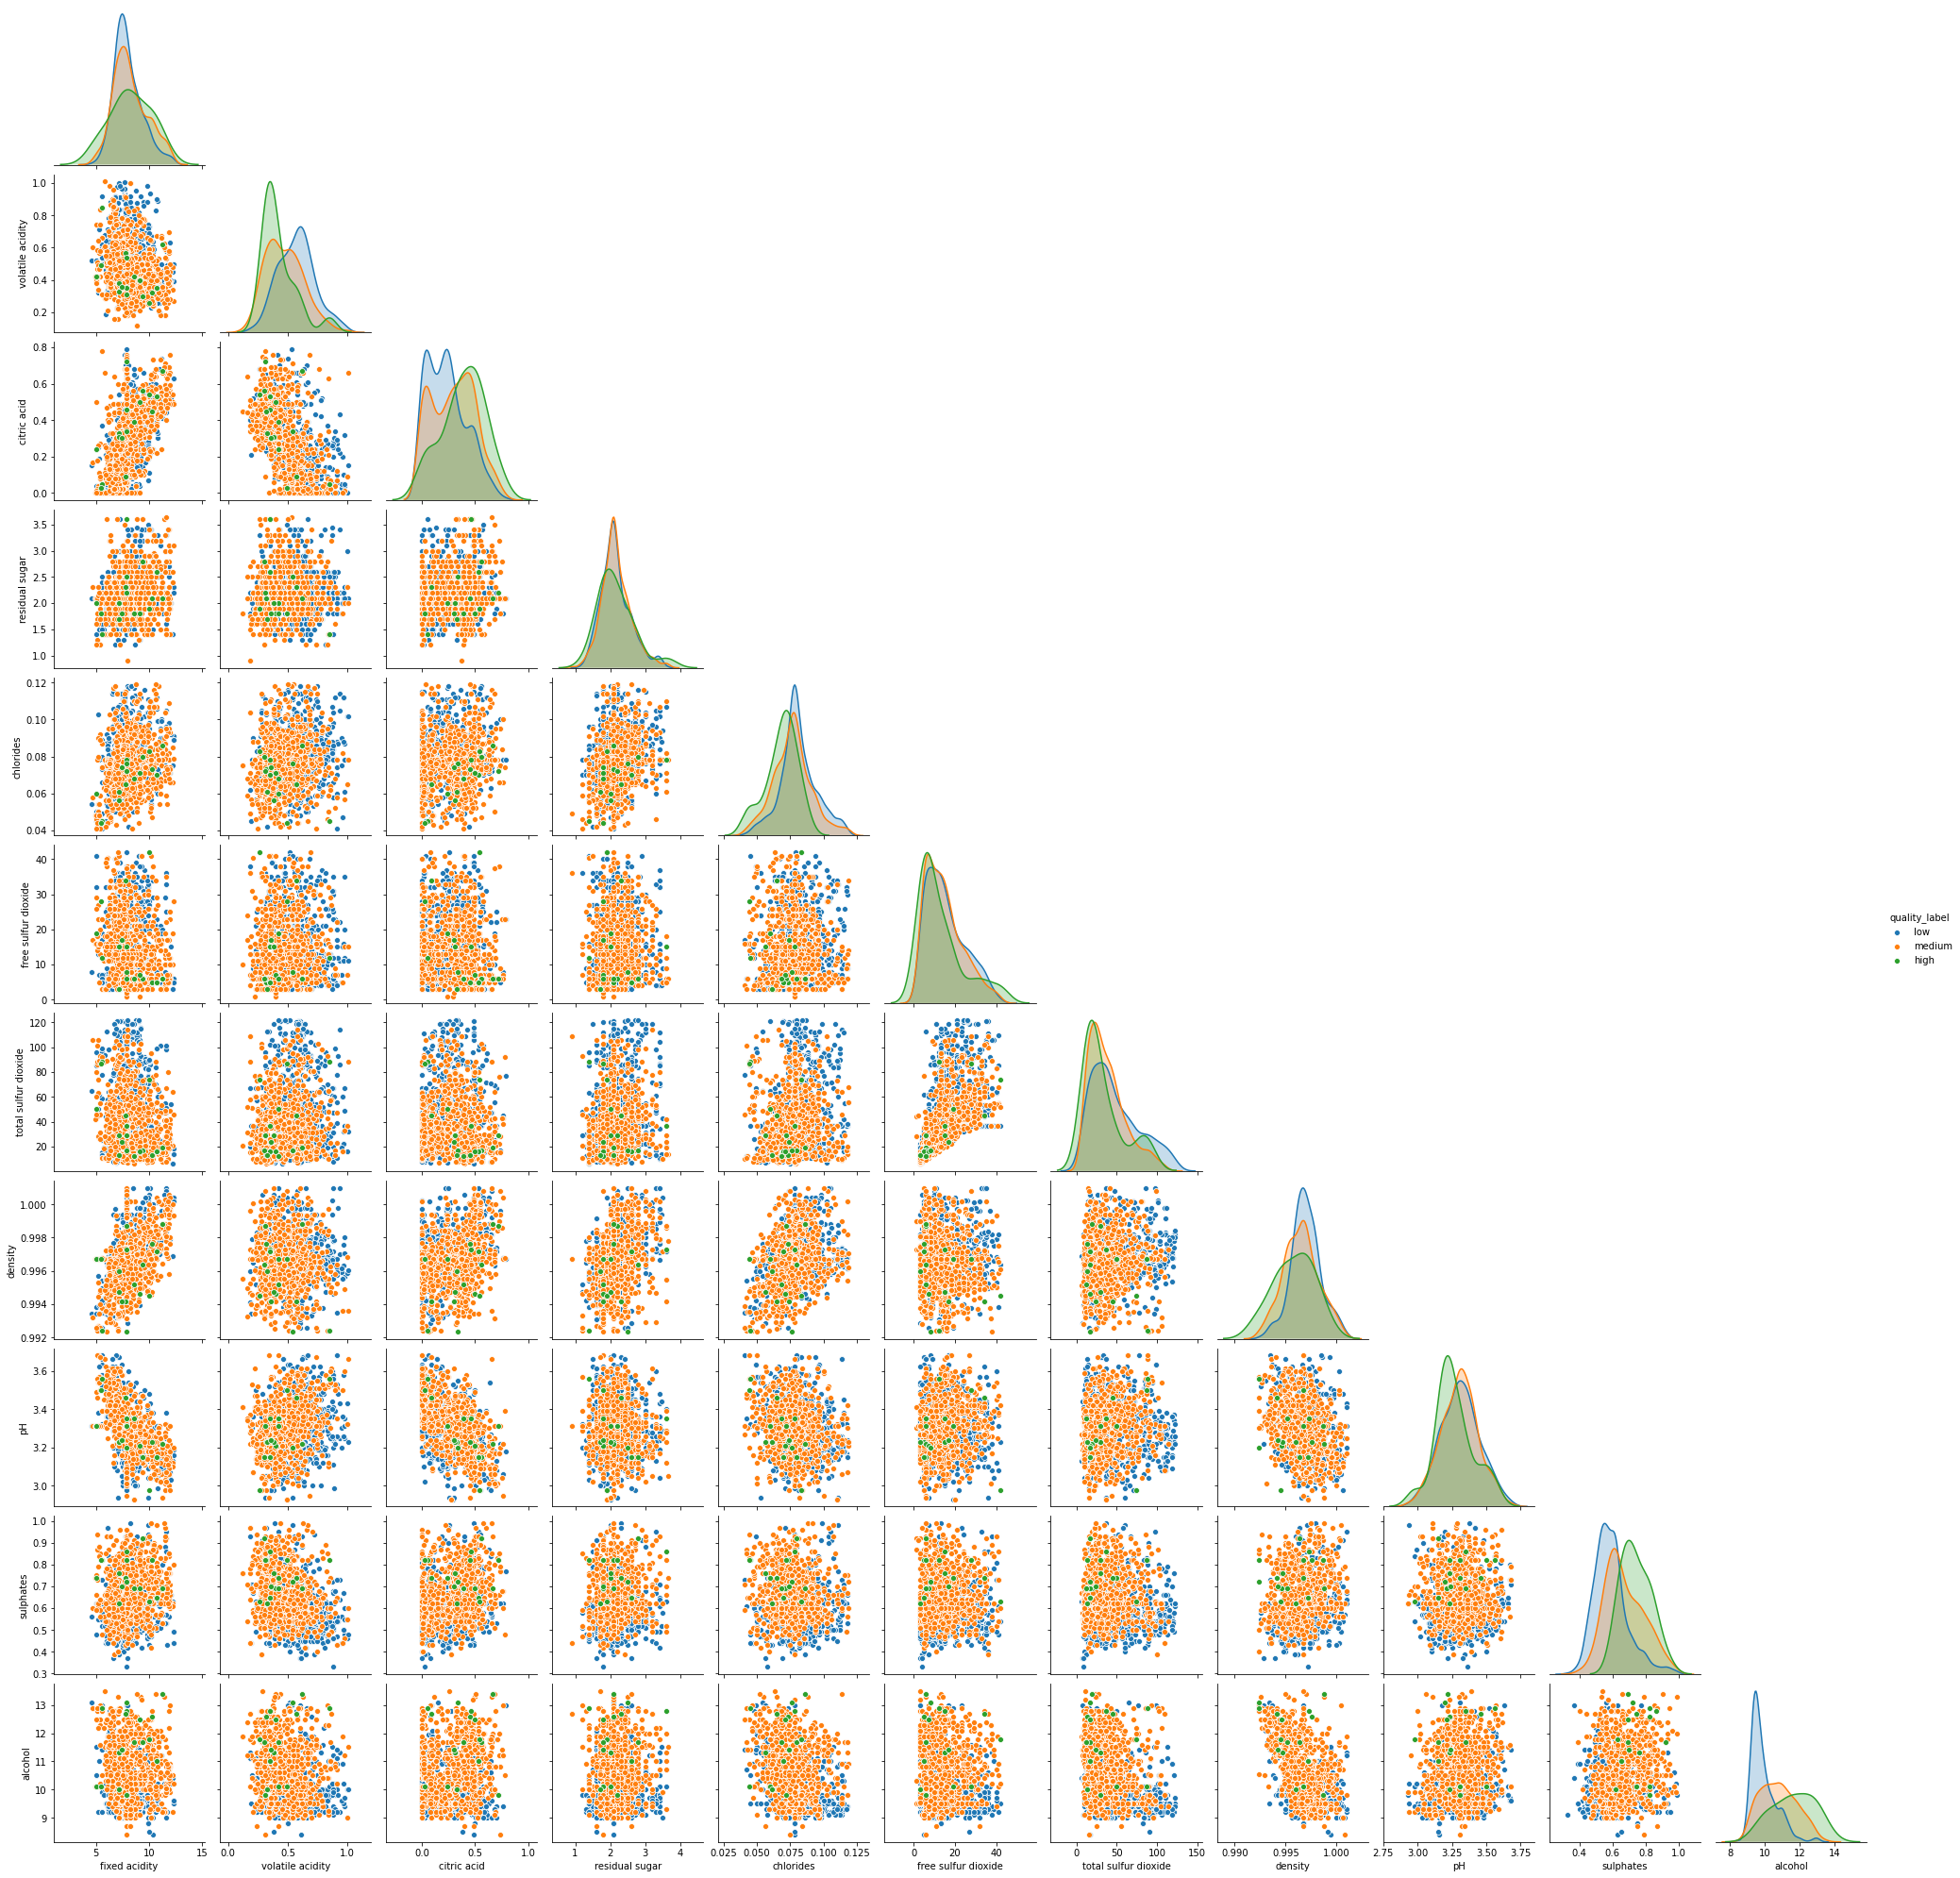

In [19]:
print(f'Red wine features pairwise plots by quality:')
sns.pairplot(wine_qual_df[wine_qual_df['type']=='red'].drop(columns=['quality']),  hue='quality_label', corner=True)

White wine features pairwise plots by quality:


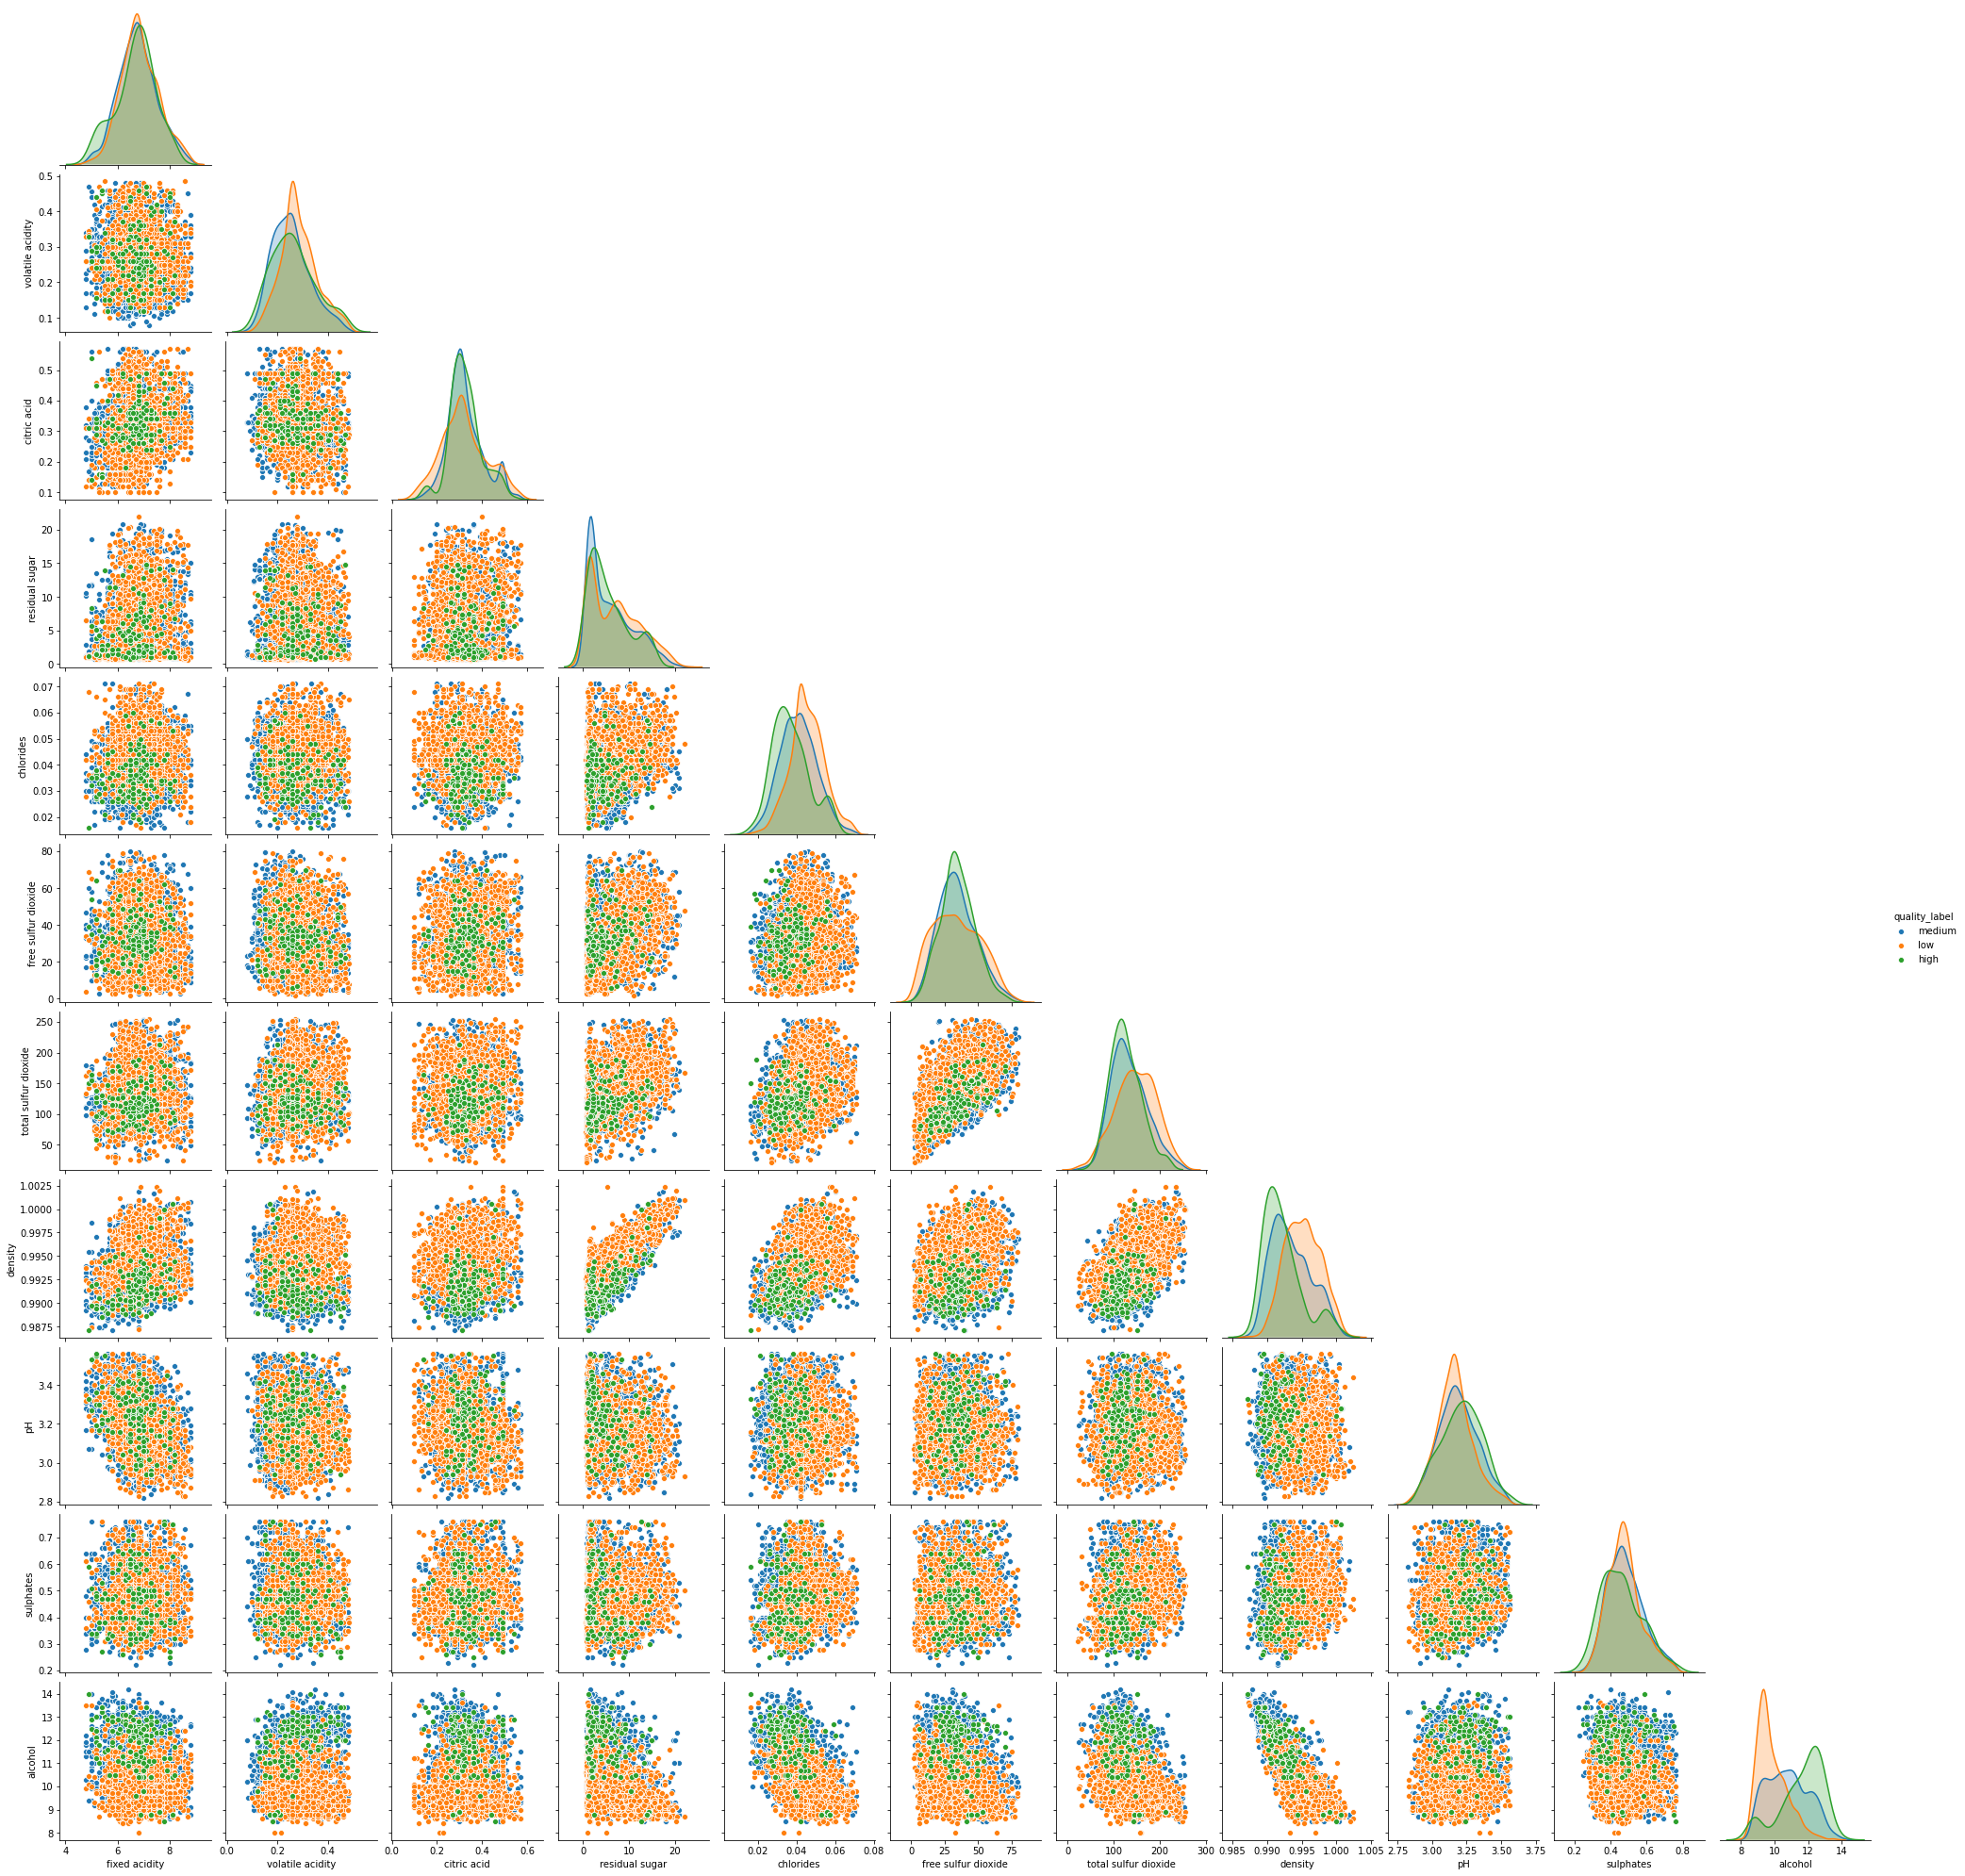

In [20]:
print(f'White wine features pairwise plots by quality:')
sns.pairplot(wine_qual_df[wine_qual_df['type']=='white'].drop(columns=['quality']),  hue='quality_label', corner=True)

На диаграммах рассеивания видим уже знакомые корреляции признаков, и грустную картину о том, что кластеры наши сильно смешаны.
Также впервые смотрим на распределения признаков, и можно заметить, что многие признаки имеют бимодальное распределение, что не есть хорошо, причиной может быть немного грубое разбиение оценок на категории, либо ненормальное оценивание вин "экспертами" (во всех смыслах этого слова).  

Стандартизируем значения набора данных, это необходимо, так как масштаб значений напрямую влияет на получаемые расстояния в большинстве алгоритмов кластеризации:

In [21]:
from sklearn import preprocessing

stand_transformer = preprocessing.StandardScaler()



stand_transf = stand_transformer.fit_transform(wine_qual_df.loc[:, chemical_feats])

stand_df = pd.DataFrame(stand_transf, columns=chemical_feats)
stand_df[['quality_label', 'type']] = wine_qual_df.loc[:,['quality_label', 'type']]

    

In [16]:
X = stand_df.drop(columns=['quality_label']).copy()
y = stand_df.quality_label.copy()

X.replace({'red': 0, 'white': 1}, inplace=True) 
y.replace({'low': 0, 'medium': 1, 'high': 2}, inplace=True) 


Функция для расчета среднего попарного внутрикластерного и межкластерного расстояния:

In [17]:
import functools
from sklearn.metrics import pairwise_distances_chunked
from sklearn.metrics.cluster._unsupervised import _silhouette_reduce

def clust_dist(X, labels, *, metric='euclidean', **kwds):
    X = X.loc[~(labels==-1), : ]
    labels = labels[np.where(labels!=-1)]
    
    
    label_freqs = np.bincount(labels)
    reduce_func = functools.partial(_silhouette_reduce,
                                    labels=labels, label_freqs=label_freqs)
    results = zip(*pairwise_distances_chunked(X, reduce_func=reduce_func,
                                              **kwds))
    intra_clust_dists, inter_clust_dists = results
    intra_clust_dists = np.concatenate(intra_clust_dists)
    inter_clust_dists = np.concatenate(inter_clust_dists)
    
    # Нормализация внутрикласторных расстояний по частоте кластеров
    denom = (label_freqs - 1).take(labels, mode='clip')
    with np.errstate(divide="ignore", invalid="ignore"):
        intra_clust_dists /= denom
        
    intra_clust_dists = np.nan_to_num(intra_clust_dists)
    inter_clust_dists = np.nan_to_num(inter_clust_dists)
    
    return np.mean(intra_clust_dists), np.mean(inter_clust_dists)

In [20]:
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score, calinski_harabasz_score
from sklearn import cluster
from timeit import default_timer as timer



def test_clust_est(X, y, est_dict):
    
    clust_lbl_df = pd.DataFrame()
    clust_lbl_df['labels'] = y.values
    
    for cluster_alg in est_dict.keys():
        print(f'============ Cluster algorithm: {cluster_alg} ============\n')
        t_start = timer()
        est = est_dict[cluster_alg]
        labels_pred = est.fit_predict(X, y)
        t_stop = timer()
        print("time: {:.4f}s\n".format(t_stop-t_start))

        n_clusters_ = len(set(labels_pred))- (1 if -1 in labels_pred else 0)
        print('Amount of clusters:', n_clusters_,'\n')
        
        clust_lbl_df[f'{cluster_alg}_labels'] = labels_pred
        
        if n_clusters_ == 1:
            continue
            
        print(f'Adjusted rand score: {adjusted_rand_score(y, labels_pred)}\n')
        print(f'Intra- and inter-cluster distance:{clust_dist(X, labels_pred)}\n')
        print(f'V_measure score: {v_measure_score(y, labels_pred)}\n')
        print(f'Silhouette score: {silhouette_score(X, labels_pred)}\n')
        print(f'Calinski-Harabasz score: {calinski_harabasz_score(X, labels_pred)}\n')
        
    return clust_lbl_df



In [22]:
estimators = {'K-means': cluster.KMeans(n_clusters=3, random_state=42),
              'MeanShift': cluster.MeanShift(n_jobs=-1),
              'DBSCAN': cluster.DBSCAN(n_jobs=-1),
              'AffinityPropagation': cluster.AffinityPropagation(random_state=42)}

In [120]:
norm_clust_lbls = test_clust_est(X, y, estimators)

============ Cluster algorithm: K-means ============

time: 0.1166s

Amount of clusters: 3 

Balanced accuracy score: 0.22960736021273706

Adjusted rand score: 0.037914847098731795

Intra- and inter-cluster distance:(3.387689113451883, 4.642299017951482)

V_measure score: 0.028455388004670932

Silhouette score: 0.25925309696363963

Calinski-Harabasz score: 2527.8945755603645

============ Cluster algorithm: MeanShift ============

time: 29.6367s

Amount of clusters: 1 

============ Cluster algorithm: DBSCAN ============

time: 0.1407s

Amount of clusters: 31 

Balanced accuracy score: 0.0007053551275567785

Adjusted rand score: -0.003611866258715682

Intra- and inter-cluster distance:(0.14866528575850227, 1.5683640154142002)

V_measure score: 0.04222152261087275

Silhouette score: -0.42825615761644353

Calinski-Harabasz score: 6.371206340178579

============ Cluster algorithm: AffinityPropagation ============

time: 225.7651s

Amount of clusters: 221 

Balanced accuracy score: 0.00316

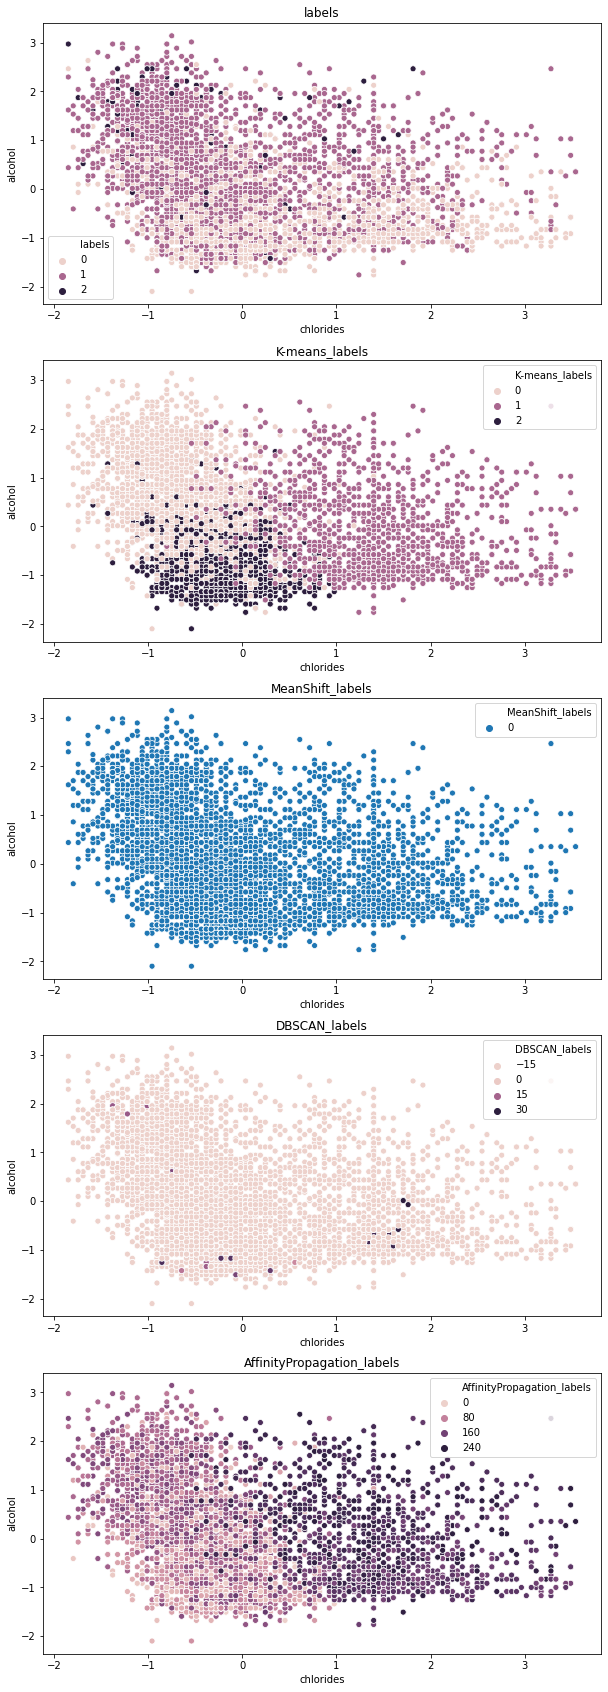

In [121]:
_, axs = plt.subplots(norm_clust_lbls.shape[1], figsize=(10,30))

for i, label in enumerate(norm_clust_lbls.columns):
    sns.scatterplot(x=X.chlorides, y=X.alcohol, hue=norm_clust_lbls[label], ax=axs[i])
    axs[i].set_title(f'{label}')

По диаграммам рассеивания и значениям метрик можем сделать вывод, что задача кластеризации вина в соответствии с оценками трудновыполнима, так как классы смешаны, помимо этого, объекты оценки *high* распределены в пространстве признаков таким образом, что не имеют явного скопления объектов, то есть плотности кластера, в совокупности со смешением с объектами других кластеров задача выделить кластер высокооцененного вина стоновится недостижимой.